## Load Libraries

In [1]:
import pysal as ps
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import datetime

from math import ceil
from geopandas import GeoDataFrame
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering
from esda.adbscan import ADBSCAN

from scipy.cluster.hierarchy import dendrogram

import spopt
from spopt.region import MaxPHeuristic as MaxP
import matplotlib.pyplot as plt
%matplotlib inline

import libpysal
import warnings

In [2]:
now = datetime.datetime.now()
print("Last executed: " + now.strftime("%Y-%m-%d %H:%M:%S"))

Last executed: 2022-04-22 07:32:56


## Load Data

In [3]:
# load neighbourhoods
nbs = gpd.read_file('data/geo/tor_nbs.gpkg')
nbs.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   _id            140 non-null    int64   
 1   Hood_ID        140 non-null    int64   
 2   Neighbourhood  140 non-null    object  
 3   Pop            140 non-null    int64   
 4   geometry       140 non-null    geometry
dtypes: geometry(1), int64(3), object(1)
memory usage: 5.6+ KB


In [4]:
# load crime data
crime = gpd.read_file("data/geo/crime.gpkg")
crime.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 275494 entries, 0 to 275493
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   premises_type   275494 non-null  object  
 1   MCI             275494 non-null  object  
 2   Hood_ID         275494 non-null  int64   
 3   Neighbourhood   275494 non-null  object  
 4   ObjectId        275494 non-null  int64   
 5   TimeSeries      275494 non-null  object  
 6   lockdownNo      275494 non-null  object  
 7   lockdownStatus  275494 non-null  int64   
 8   geometry        275494 non-null  geometry
dtypes: geometry(1), int64(3), object(5)
memory usage: 18.9+ MB


In [5]:
# peek at data
crime.head()

,premises_type,MCI,Hood_ID,Neighbourhood,ObjectId,TimeSeries,lockdownNo,lockdownStatus,geometry
0,House,Assault,1,West Humber-Clairville,1,2014-03-02T05:00:00,none,0,POINT (-79.59033 43.73401)
1,Commercial,Break and Enter,1,West Humber-Clairville,5,2014-01-03T05:00:00,none,0,POINT (-79.58644 43.69711)
2,Commercial,Theft Over,1,West Humber-Clairville,6,2014-01-08T05:00:00,none,0,POINT (-79.58493 43.67834)
3,House,Break and Enter,1,West Humber-Clairville,7,2014-01-08T05:00:00,none,0,POINT (-79.62004 43.72299)
4,Commercial,Theft Over,1,West Humber-Clairville,8,2014-01-06T05:00:00,none,0,POINT (-79.58493 43.67834)


In [6]:
# see which crimes are the most common
crime.MCI.value_counts()

Assault            147963
Break and Enter     55908
Auto Theft          35824
Robbery             26838
Theft Over           8961
Name: MCI, dtype: int64

In [7]:
# assaults represent over half all crime!

## Calculate Crime Rates

In [8]:
# for this cluster analysis we want to understand the differences the first lockdown had on the clustering of crime types throughout the city
# to determine this, we will calculate the crime rate for each of our 5 major crime indicators for each of our 140 neighbourhoods
    # first for the first lockdown in 2020 which occured from '2020-03-23 to 2020-07-31'
    # second for the exact same period from the year previous in 2019 from '2019-03-23 to 2019-07-31'
# we will then complete a cluster analysis for each of these two time periods

# we will start with the first lockdown
crime.lockdownNo.value_counts()

none      250721
first      11542
second      8412
third       4819
Name: lockdownNo, dtype: int64

In [9]:
# create subset of 2020 lockdown period (LD) and 2019 non-lockdown period (noLD)
mask1 = (crime['TimeSeries'] > '2020-03-23') & (crime['TimeSeries'] < '2020-07-31')
mask2 = (crime['TimeSeries'] > '2019-03-23') & (crime['TimeSeries'] < '2019-07-31')
LD = crime.loc[mask1]
noLD = crime.loc[mask2]

# confirm it worked
print(LD.shape)
print(noLD.shape)

(11542, 9)
(14379, 9)


In [10]:
# check dataframe 1
LD.head()

,premises_type,MCI,Hood_ID,Neighbourhood,ObjectId,TimeSeries,lockdownNo,lockdownStatus,geometry
3181,Outside,Assault,1,West Humber-Clairville,3201,2020-06-26T04:00:00,first,1,POINT (-79.59857 43.74150)
3182,Commercial,Assault,1,West Humber-Clairville,3202,2020-06-27T04:00:00,first,1,POINT (-79.61689 43.72375)
3183,Apartment,Break and Enter,1,West Humber-Clairville,3203,2020-06-17T04:00:00,first,1,POINT (-79.60317 43.73198)
3184,Commercial,Assault,1,West Humber-Clairville,3204,2020-06-27T04:00:00,first,1,POINT (-79.60316 43.73414)
3185,Commercial,Assault,1,West Humber-Clairville,3205,2020-06-27T04:00:00,first,1,POINT (-79.60316 43.73414)


In [11]:
# check dataframe 2
noLD.head()

,premises_type,MCI,Hood_ID,Neighbourhood,ObjectId,TimeSeries,lockdownNo,lockdownStatus,geometry
2990,Commercial,Theft Over,1,West Humber-Clairville,3010,2019-07-08T04:00:00,none,0,POINT (-79.59281 43.68082)
3041,House,Assault,1,West Humber-Clairville,3061,2019-07-14T04:00:00,none,0,POINT (-79.59857 43.74150)
3052,Commercial,Theft Over,1,West Humber-Clairville,3072,2019-07-12T04:00:00,none,0,POINT (-79.58644 43.69711)
3055,Apartment,Assault,1,West Humber-Clairville,3075,2019-05-27T04:00:00,none,0,POINT (-79.59350 43.73377)
3078,House,Assault,1,West Humber-Clairville,3098,2019-05-01T04:00:00,none,0,POINT (-79.59883 43.74399)


In [12]:
# gets crime counts per neighbourhood by crime type
LD = LD.groupby(["Hood_ID", "MCI"], as_index=False)["ObjectId"].count()
noLD = noLD.groupby(["Hood_ID", "MCI"], as_index=False)["ObjectId"].count()

# change name of ObjectID to Count
LD.rename(columns={'ObjectId': 'Total'}, inplace=True)
noLD.rename(columns={'ObjectId': 'Total'}, inplace=True)

# confirm LD
LD

,Hood_ID,MCI,Total
0,1,Assault,78
1,1,Auto Theft,139
2,1,Break and Enter,29
3,1,Robbery,22
4,1,Theft Over,21
...,...,...,...
645,139,Theft Over,1
646,140,Assault,14
647,140,Auto Theft,4
648,140,Break and Enter,1


In [13]:
# confirm noLD
noLD

,Hood_ID,MCI,Total
0,1,Assault,101
1,1,Auto Theft,168
2,1,Break and Enter,46
3,1,Robbery,17
4,1,Theft Over,23
...,...,...,...
674,140,Assault,13
675,140,Auto Theft,3
676,140,Break and Enter,3
677,140,Robbery,4


In [14]:
# split each crime time into its own column
LDSplit = LD.pivot_table(values='Total', index=LD.index, columns='MCI', aggfunc='first')
noLDSplit = noLD.pivot_table(values='Total', index=noLD.index, columns='MCI', aggfunc='first')

# confirm LD
LDSplit

MCI,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
0,78.0,NaN,NaN,NaN,NaN
1,NaN,139.0,NaN,NaN,NaN
2,NaN,NaN,29.0,NaN,NaN
3,NaN,NaN,NaN,22.0,NaN
4,NaN,NaN,NaN,NaN,21.0
...,...,...,...,...,...
645,NaN,NaN,NaN,NaN,1.0
646,14.0,NaN,NaN,NaN,NaN
647,NaN,4.0,NaN,NaN,NaN
648,NaN,NaN,1.0,NaN,NaN


In [15]:
# confirm noLD
noLDSplit

MCI,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
0,101.0,NaN,NaN,NaN,NaN
1,NaN,168.0,NaN,NaN,NaN
2,NaN,NaN,46.0,NaN,NaN
3,NaN,NaN,NaN,17.0,NaN
4,NaN,NaN,NaN,NaN,23.0
...,...,...,...,...,...
674,13.0,NaN,NaN,NaN,NaN
675,NaN,3.0,NaN,NaN,NaN
676,NaN,NaN,3.0,NaN,NaN
677,NaN,NaN,NaN,4.0,NaN


In [16]:
# add back into dataframe
LD = LD.join(LDSplit, lsuffix="_left")
noLD = noLD.join(noLDSplit, lsuffix="_left")

# confirm LD
LD

,Hood_ID,MCI,Total,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
0,1,Assault,78,78.0,NaN,NaN,NaN,NaN
1,1,Auto Theft,139,NaN,139.0,NaN,NaN,NaN
2,1,Break and Enter,29,NaN,NaN,29.0,NaN,NaN
3,1,Robbery,22,NaN,NaN,NaN,22.0,NaN
4,1,Theft Over,21,NaN,NaN,NaN,NaN,21.0
...,...,...,...,...,...,...,...,...
645,139,Theft Over,1,NaN,NaN,NaN,NaN,1.0
646,140,Assault,14,14.0,NaN,NaN,NaN,NaN
647,140,Auto Theft,4,NaN,4.0,NaN,NaN,NaN
648,140,Break and Enter,1,NaN,NaN,1.0,NaN,NaN


In [17]:
# confirm noLD
noLD

,Hood_ID,MCI,Total,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
0,1,Assault,101,101.0,NaN,NaN,NaN,NaN
1,1,Auto Theft,168,NaN,168.0,NaN,NaN,NaN
2,1,Break and Enter,46,NaN,NaN,46.0,NaN,NaN
3,1,Robbery,17,NaN,NaN,NaN,17.0,NaN
4,1,Theft Over,23,NaN,NaN,NaN,NaN,23.0
...,...,...,...,...,...,...,...,...
674,140,Assault,13,13.0,NaN,NaN,NaN,NaN
675,140,Auto Theft,3,NaN,3.0,NaN,NaN,NaN
676,140,Break and Enter,3,NaN,NaN,3.0,NaN,NaN
677,140,Robbery,4,NaN,NaN,NaN,4.0,NaN


In [18]:
# delete columns
cols2drop1 = ['MCI']
for col in LD.columns:
    if col in cols2drop1:
        LD.drop(col, inplace=True, axis=1)

cols2drop2 = ['MCI']
for col in noLD.columns:
    if col in cols2drop2:
        noLD.drop(col, inplace=True, axis=1)

# confirm LD
LD

,Hood_ID,Total,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
0,1,78,78.0,NaN,NaN,NaN,NaN
1,1,139,NaN,139.0,NaN,NaN,NaN
2,1,29,NaN,NaN,29.0,NaN,NaN
3,1,22,NaN,NaN,NaN,22.0,NaN
4,1,21,NaN,NaN,NaN,NaN,21.0
...,...,...,...,...,...,...,...
645,139,1,NaN,NaN,NaN,NaN,1.0
646,140,14,14.0,NaN,NaN,NaN,NaN
647,140,4,NaN,4.0,NaN,NaN,NaN
648,140,1,NaN,NaN,1.0,NaN,NaN


In [19]:
# confirm noLD
noLD

,Hood_ID,Total,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
0,1,101,101.0,NaN,NaN,NaN,NaN
1,1,168,NaN,168.0,NaN,NaN,NaN
2,1,46,NaN,NaN,46.0,NaN,NaN
3,1,17,NaN,NaN,NaN,17.0,NaN
4,1,23,NaN,NaN,NaN,NaN,23.0
...,...,...,...,...,...,...,...
674,140,13,13.0,NaN,NaN,NaN,NaN
675,140,3,NaN,3.0,NaN,NaN,NaN
676,140,3,NaN,NaN,3.0,NaN,NaN
677,140,4,NaN,NaN,NaN,4.0,NaN


In [20]:
# merge all crime stats into one row per neighbourhood
LD = LD.groupby("Hood_ID").sum()
noLD = noLD.groupby("Hood_ID").sum()

# confirm LD
LD

,Total,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
Hood_ID,,,,,,
1,289,78.0,139.0,29.0,22.0,21.0
2,100,45.0,38.0,5.0,8.0,4.0
3,50,19.0,19.0,7.0,3.0,2.0
4,41,17.0,19.0,5.0,0.0,0.0
5,32,12.0,15.0,5.0,0.0,0.0
...,...,...,...,...,...,...
136,171,117.0,21.0,23.0,10.0,0.0
137,151,101.0,18.0,20.0,8.0,4.0
138,74,51.0,8.0,6.0,6.0,3.0


In [21]:
# confirm noLD
noLD

,Total,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
Hood_ID,,,,,,
1,355,101.0,168.0,46.0,17.0,23.0
2,163,94.0,35.0,7.0,22.0,5.0
3,65,29.0,20.0,11.0,3.0,2.0
4,51,21.0,17.0,7.0,6.0,0.0
5,39,17.0,10.0,3.0,7.0,2.0
...,...,...,...,...,...,...
136,266,179.0,18.0,35.0,30.0,4.0
137,230,155.0,20.0,38.0,15.0,2.0
138,132,72.0,16.0,23.0,16.0,5.0


In [22]:
# add population data
LD = pd.merge(LD, nbs, on=['Hood_ID'])
noLD = pd.merge(noLD, nbs, on=['Hood_ID'])

# delete columns
cols2drop1 = ['_id', 'Neighbourhood', 'geometry']
for col in LD.columns:
    if col in cols2drop1:
        LD.drop(col, inplace=True, axis=1)
cols2drop2 = ['_id']
for col in noLD.columns:
    if col in cols2drop2:
        noLD.drop(col, inplace=True, axis=1)

# reorder columns for clarity
LD = LD[['Hood_ID', 'Pop', 'Total', 'Assault', 'Auto Theft', 'Break and Enter', 'Robbery', 'Theft Over']]
noLD = noLD[['Hood_ID', 'Pop', 'Total', 'Assault', 'Auto Theft', 'Break and Enter', 'Robbery', 'Theft Over']]

# confirm LD
LD

,Hood_ID,Pop,Total,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
0,1,33312,289,78.0,139.0,29.0,22.0,21.0
1,2,32954,100,45.0,38.0,5.0,8.0,4.0
2,3,10360,50,19.0,19.0,7.0,3.0,2.0
3,4,10529,41,17.0,19.0,5.0,0.0,0.0
4,5,9456,32,12.0,15.0,5.0,0.0,0.0
...,...,...,...,...,...,...,...,...
135,136,27392,171,117.0,21.0,23.0,10.0,0.0
136,137,53485,151,101.0,18.0,20.0,8.0,4.0
137,138,22776,74,51.0,8.0,6.0,6.0,3.0
138,139,16724,90,71.0,6.0,6.0,6.0,1.0


In [23]:
# confirm noLD
noLD

,Hood_ID,Pop,Total,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
0,1,33312,355,101.0,168.0,46.0,17.0,23.0
1,2,32954,163,94.0,35.0,7.0,22.0,5.0
2,3,10360,65,29.0,20.0,11.0,3.0,2.0
3,4,10529,51,21.0,17.0,7.0,6.0,0.0
4,5,9456,39,17.0,10.0,3.0,7.0,2.0
...,...,...,...,...,...,...,...,...
135,136,27392,266,179.0,18.0,35.0,30.0,4.0
136,137,53485,230,155.0,20.0,38.0,15.0,2.0
137,138,22776,132,72.0,16.0,23.0,16.0,5.0
138,139,16724,86,65.0,6.0,9.0,6.0,0.0


In [24]:
# convert datatypes
for c in ['Pop', 'Total', 'Assault', 'Auto Theft', 'Break and Enter', 'Robbery', 'Theft Over']:
    LD[c] = LD[c].astype('int')
for c in ['Pop', 'Total', 'Assault', 'Auto Theft', 'Break and Enter', 'Robbery', 'Theft Over']:
    noLD[c] = noLD[c].astype('int')

# confirm changes
LD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140 entries, 0 to 139
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Hood_ID          140 non-null    int64
 1   Pop              140 non-null    int64
 2   Total            140 non-null    int64
 3   Assault          140 non-null    int64
 4   Auto Theft       140 non-null    int64
 5   Break and Enter  140 non-null    int64
 6   Robbery          140 non-null    int64
 7   Theft Over       140 non-null    int64
dtypes: int64(8)
memory usage: 9.8 KB


In [25]:
# confirm noLD
noLD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140 entries, 0 to 139
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Hood_ID          140 non-null    int64
 1   Pop              140 non-null    int64
 2   Total            140 non-null    int64
 3   Assault          140 non-null    int64
 4   Auto Theft       140 non-null    int64
 5   Break and Enter  140 non-null    int64
 6   Robbery          140 non-null    int64
 7   Theft Over       140 non-null    int64
dtypes: int64(8)
memory usage: 9.8 KB


In [26]:
# replace crime counts with crime rates using [(crime count / Pop)*100,000] for each crime type

for c in ['Total', 'Assault', 'Auto Theft', 'Break and Enter', 'Robbery', 'Theft Over']:
    LD[c] = ((LD[c]/LD['Pop'])*100000).round(decimals = 2)
for c in ['Total', 'Assault', 'Auto Theft', 'Break and Enter', 'Robbery', 'Theft Over']:
    noLD[c] = ((noLD[c]/noLD['Pop'])*100000).round(decimals = 2)
    
# confirm LD
LD

,Hood_ID,Pop,Total,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
0,1,33312,867.56,234.15,417.27,87.06,66.04,63.04
1,2,32954,303.45,136.55,115.31,15.17,24.28,12.14
2,3,10360,482.63,183.40,183.40,67.57,28.96,19.31
3,4,10529,389.40,161.46,180.45,47.49,0.00,0.00
4,5,9456,338.41,126.90,158.63,52.88,0.00,0.00
...,...,...,...,...,...,...,...,...
135,136,27392,624.27,427.13,76.66,83.97,36.51,0.00
136,137,53485,282.32,188.84,33.65,37.39,14.96,7.48
137,138,22776,324.90,223.92,35.12,26.34,26.34,13.17
138,139,16724,538.15,424.54,35.88,35.88,35.88,5.98


In [27]:
# confirm noLD
noLD

,Hood_ID,Pop,Total,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
0,1,33312,1065.68,303.19,504.32,138.09,51.03,69.04
1,2,32954,494.63,285.25,106.21,21.24,66.76,15.17
2,3,10360,627.41,279.92,193.05,106.18,28.96,19.31
3,4,10529,484.38,199.45,161.46,66.48,56.99,0.00
4,5,9456,412.44,179.78,105.75,31.73,74.03,21.15
...,...,...,...,...,...,...,...,...
135,136,27392,971.09,653.48,65.71,127.77,109.52,14.60
136,137,53485,430.03,289.80,37.39,71.05,28.05,3.74
137,138,22776,579.56,316.12,70.25,100.98,70.25,21.95
138,139,16724,514.23,388.66,35.88,53.81,35.88,0.00


In [28]:
# delete columns
cols2drop = ['Pop']
for col in LD.columns:
    if col in cols2drop:
        LD.drop(col, inplace=True, axis=1)
cols2drop = ['Pop']
for col in noLD.columns:
    if col in cols2drop:
        noLD.drop(col, inplace=True, axis=1)
        
# rename columns for clarity  
LD.rename(columns={'Total':'TotalRate', 'Assault':'AssaultRate', 'Auto Theft':'AutoTheftRate', 'Break and Enter':'BreakEnterRate', 'Robbery':'RobberyRate', 'Theft Over':'TheftOverRate'}, inplace=True)
noLD.rename(columns={'Total':'TotalRate', 'Assault':'AssaultRate', 'Auto Theft':'AutoTheftRate', 'Break and Enter':'BreakEnterRate', 'Robbery':'RobberyRate', 'Theft Over':'TheftOverRate'}, inplace=True)

# confirm LD
LD

,Hood_ID,TotalRate,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate
0,1,867.56,234.15,417.27,87.06,66.04,63.04
1,2,303.45,136.55,115.31,15.17,24.28,12.14
2,3,482.63,183.40,183.40,67.57,28.96,19.31
3,4,389.40,161.46,180.45,47.49,0.00,0.00
4,5,338.41,126.90,158.63,52.88,0.00,0.00
...,...,...,...,...,...,...,...
135,136,624.27,427.13,76.66,83.97,36.51,0.00
136,137,282.32,188.84,33.65,37.39,14.96,7.48
137,138,324.90,223.92,35.12,26.34,26.34,13.17
138,139,538.15,424.54,35.88,35.88,35.88,5.98


In [29]:
# confirm noLD
noLD

,Hood_ID,TotalRate,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate
0,1,1065.68,303.19,504.32,138.09,51.03,69.04
1,2,494.63,285.25,106.21,21.24,66.76,15.17
2,3,627.41,279.92,193.05,106.18,28.96,19.31
3,4,484.38,199.45,161.46,66.48,56.99,0.00
4,5,412.44,179.78,105.75,31.73,74.03,21.15
...,...,...,...,...,...,...,...
135,136,971.09,653.48,65.71,127.77,109.52,14.60
136,137,430.03,289.80,37.39,71.05,28.05,3.74
137,138,579.56,316.12,70.25,100.98,70.25,21.95
138,139,514.23,388.66,35.88,53.81,35.88,0.00


In [30]:
LD = LD.groupby("Hood_ID").sum()
LD

,TotalRate,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate
Hood_ID,,,,,,
1,867.56,234.15,417.27,87.06,66.04,63.04
2,303.45,136.55,115.31,15.17,24.28,12.14
3,482.63,183.40,183.40,67.57,28.96,19.31
4,389.40,161.46,180.45,47.49,0.00,0.00
5,338.41,126.90,158.63,52.88,0.00,0.00
...,...,...,...,...,...,...
136,624.27,427.13,76.66,83.97,36.51,0.00
137,282.32,188.84,33.65,37.39,14.96,7.48
138,324.90,223.92,35.12,26.34,26.34,13.17


In [31]:
# peek at final LD data
LD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140 entries, 1 to 140
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TotalRate       140 non-null    float64
 1   AssaultRate     140 non-null    float64
 2   AutoTheftRate   140 non-null    float64
 3   BreakEnterRate  140 non-null    float64
 4   RobberyRate     140 non-null    float64
 5   TheftOverRate   140 non-null    float64
dtypes: float64(6)
memory usage: 7.7 KB


In [32]:
noLD = noLD.groupby("Hood_ID").sum()
LD

,TotalRate,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate
Hood_ID,,,,,,
1,867.56,234.15,417.27,87.06,66.04,63.04
2,303.45,136.55,115.31,15.17,24.28,12.14
3,482.63,183.40,183.40,67.57,28.96,19.31
4,389.40,161.46,180.45,47.49,0.00,0.00
5,338.41,126.90,158.63,52.88,0.00,0.00
...,...,...,...,...,...,...
136,624.27,427.13,76.66,83.97,36.51,0.00
137,282.32,188.84,33.65,37.39,14.96,7.48
138,324.90,223.92,35.12,26.34,26.34,13.17


In [33]:
# peek at final noLD data
noLD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140 entries, 1 to 140
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TotalRate       140 non-null    float64
 1   AssaultRate     140 non-null    float64
 2   AutoTheftRate   140 non-null    float64
 3   BreakEnterRate  140 non-null    float64
 4   RobberyRate     140 non-null    float64
 5   TheftOverRate   140 non-null    float64
dtypes: float64(6)
memory usage: 7.7 KB


## Explore Crime Rates

In [34]:
# summarize LD data
LD.describe()

,TotalRate,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,411.184214,214.905000,72.232286,84.529286,26.398643,13.117500
std,268.414815,166.958942,61.746442,81.713762,29.225059,13.733777
min,117.640000,29.710000,0.000000,0.000000,0.000000,0.000000
25%,249.625000,124.675000,35.277500,35.982500,9.080000,4.277500
50%,357.465000,178.900000,56.150000,63.810000,20.965000,9.540000
75%,465.312500,249.157500,88.562500,101.867500,35.272500,19.040000
max,2189.600000,1384.960000,442.980000,462.520000,243.830000,96.650000


In [35]:
# assault rate was the highest crime rate during the lockdown, followed by B&E

In [36]:
# summarize data
noLD.describe()

,TotalRate,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,513.715500,272.834143,68.405643,111.671571,43.090357,17.712857
std,319.620115,200.819377,67.815590,89.498164,42.140039,16.697344
min,180.030000,66.330000,0.000000,10.830000,0.000000,0.000000
25%,324.187500,144.050000,29.575000,60.815000,18.840000,7.980000
50%,433.285000,231.700000,52.345000,94.825000,33.515000,14.390000
75%,580.442500,323.062500,81.267500,128.277500,52.392500,22.477500
max,2170.100000,1372.250000,504.320000,691.000000,341.360000,108.540000


In [37]:
# again assualt rate also the highest not in lockdown, followed by B&E

## Crime Clustering in Lockdown from March 23, 2020 to July 31, 2020

## Preparation

In [38]:
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)

In [39]:
tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}

In [40]:
nbs = gpd.read_file('data/geo/tor_nbs.gpkg')
nbs.columns

Index(['_id', 'Hood_ID', 'Neighbourhood', 'Pop', 'geometry'], dtype='object')

In [41]:
nbs = nbs[['Hood_ID', 'Neighbourhood', 'geometry']]

In [42]:
LD = pd.merge(LD, nbs, left_on='Hood_ID', right_on='Hood_ID', how='inner').reset_index()
LD = GeoDataFrame(LD)
LD.shape

(140, 10)

In [43]:
LD.head()

,index,Hood_ID,TotalRate,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate,Neighbourhood,geometry
0,0,1,867.56,234.15,417.27,87.06,66.04,63.04,West Humber-Clairville,"POLYGON ((-79.55236 43.70947, -79.55238 43.709..."
1,1,2,303.45,136.55,115.31,15.17,24.28,12.14,Mount Olive-Silverstone-Jamestown,"POLYGON ((-79.60338 43.75786, -79.60205 43.758..."
2,2,3,482.63,183.40,183.40,67.57,28.96,19.31,Thistletown-Beaumond Heights,"POLYGON ((-79.57751 43.73384, -79.57806 43.734..."
3,3,4,389.40,161.46,180.45,47.49,0.00,0.00,Rexdale-Kipling,"POLYGON ((-79.55512 43.71510, -79.55504 43.714..."
4,4,5,338.41,126.90,158.63,52.88,0.00,0.00,Elms-Old Rexdale,"POLYGON ((-79.55512 43.71510, -79.55569 43.716..."


### Raw Total Crime Distribution - Lockdown 

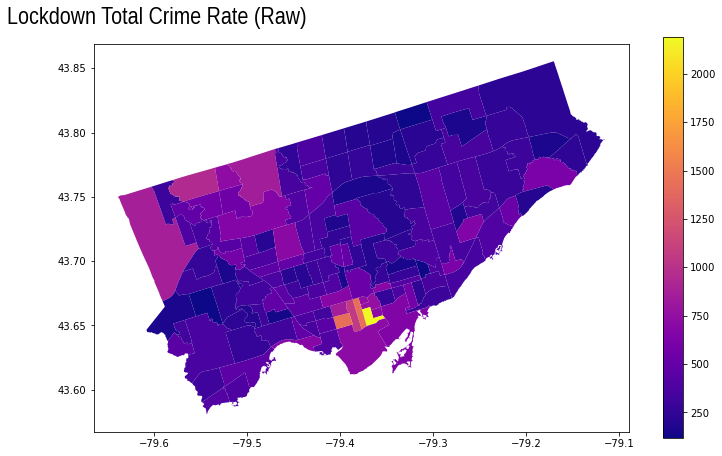

In [44]:
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
LD.plot(column='TotalRate', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

f.subplots_adjust(top=0.92)
f.suptitle(f"Lockdown Total Crime Rate (Raw)", x=0.025, size=24, **tfont);
#plt.savefig('Cluster-House-Prices-Raw.png', dpi=150)

### Raw Assault Distribution - Lockdown 

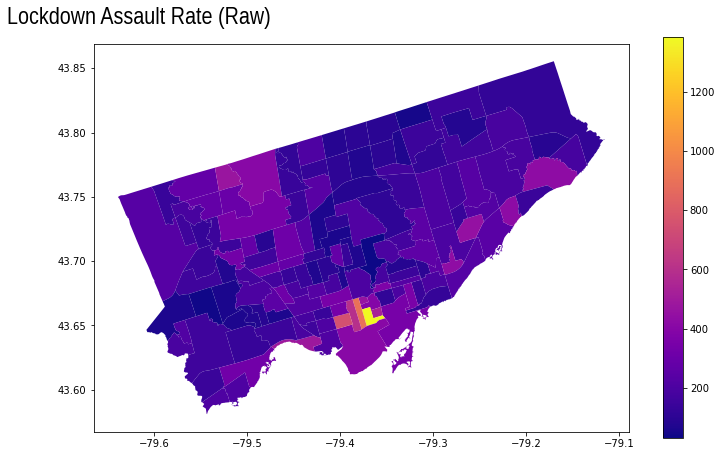

In [45]:
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
LD.plot(column='AssaultRate', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

f.subplots_adjust(top=0.92)
f.suptitle(f"Lockdown Assault Rate (Raw)", x=0.025, size=24, **tfont);
#plt.savefig('Cluster-House-Prices-Raw.png', dpi=150)

### Raw Auto Theft Distribution - Lockdown 

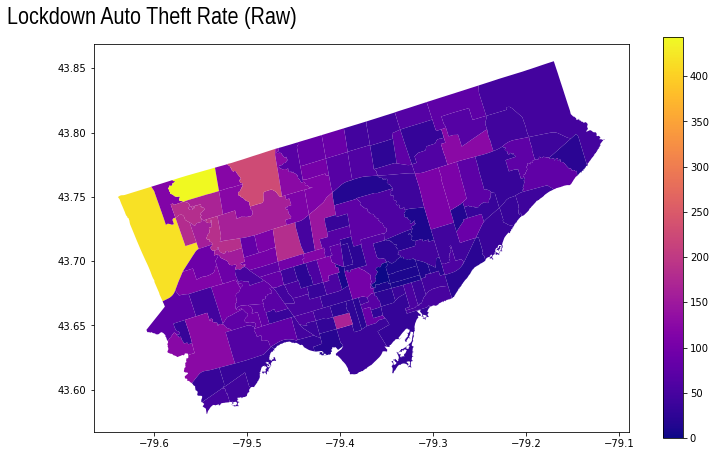

In [46]:
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
LD.plot(column='AutoTheftRate', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

f.subplots_adjust(top=0.92)
f.suptitle(f"Lockdown Auto Theft Rate (Raw)", x=0.025, size=24, **tfont);
#plt.savefig('Cluster-House-Prices-Raw.png', dpi=150)

### Raw Break and Enter Distribution - Lockdown 

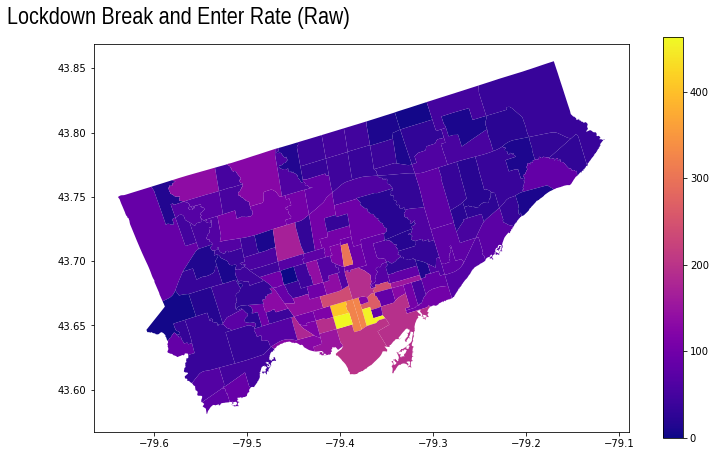

In [47]:
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
LD.plot(column='BreakEnterRate', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

f.subplots_adjust(top=0.92)
f.suptitle(f"Lockdown Break and Enter Rate (Raw)", x=0.025, size=24, **tfont);
#plt.savefig('Cluster-House-Prices-Raw.png', dpi=150)

### Raw Robbery Distribution - Lockdown 

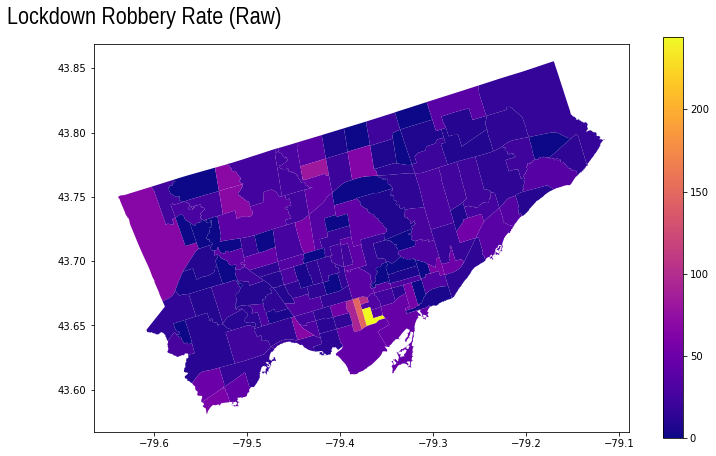

In [48]:
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
LD.plot(column='RobberyRate', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

f.subplots_adjust(top=0.92)
f.suptitle(f"Lockdown Robbery Rate (Raw)", x=0.025, size=24, **tfont);
#plt.savefig('Cluster-House-Prices-Raw.png', dpi=150)

### Raw Theft Over Distribution - Lockdown 

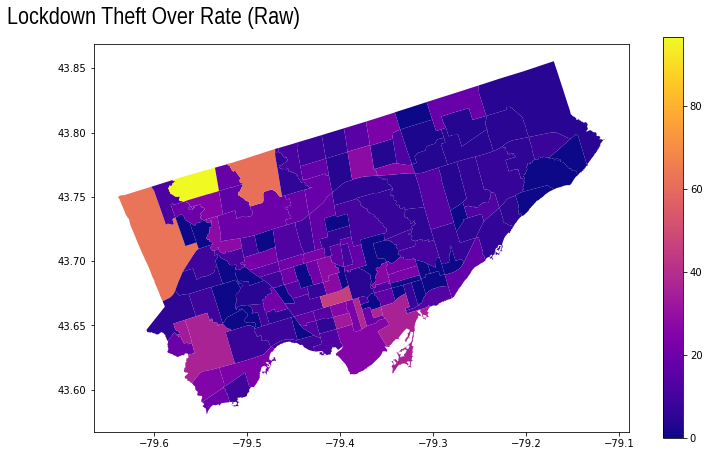

In [49]:
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
LD.plot(column='TheftOverRate', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

f.subplots_adjust(top=0.92)
f.suptitle(f"Lockdown Theft Over Rate (Raw)", x=0.025, size=24, **tfont);
#plt.savefig('Cluster-House-Prices-Raw.png', dpi=150)

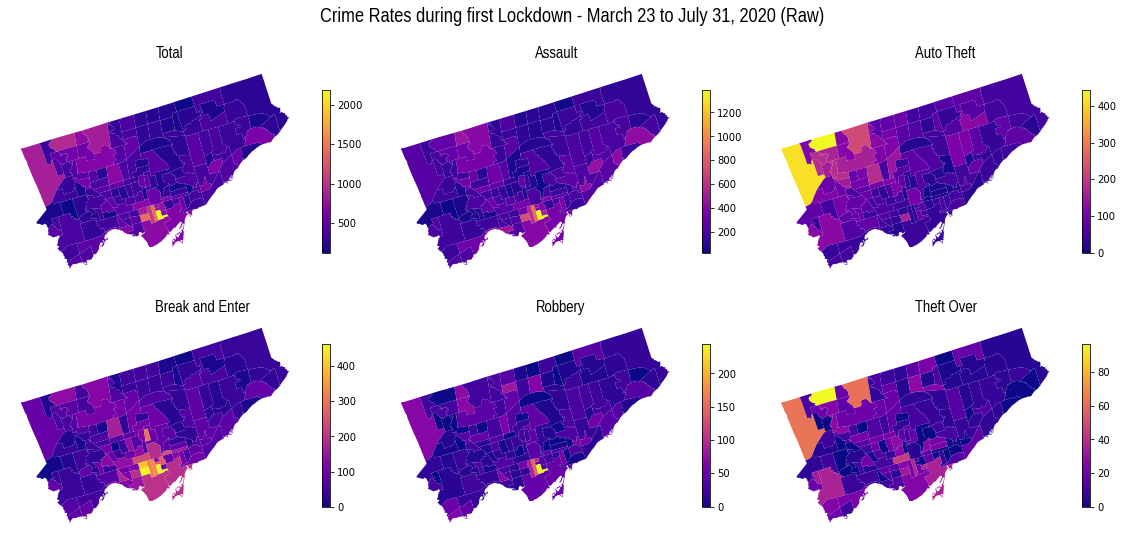

In [50]:
# plots combined 

f = plt.figure()
f.set_size_inches(16, 8)
f.suptitle(f"Crime Rates during first Lockdown - March 23 to July 31, 2020 (Raw)", ha='center', size=20, **tfont)

ax1 = plt.subplot(2, 3, 1)
plt.title('Total', fontsize=16, color='black', **tfont)
plt.axis('off')
LD.plot(column='TotalRate', legend=True, legend_kwds={'shrink': 0.6}, cmap='plasma', figsize=(6,4), ax=ax1)
 
ax2 = plt.subplot(2, 3, 2)
plt.title('Assault', fontsize=16, color='black', **tfont)
plt.axis('off')
LD.plot(column='AssaultRate', legend=True, legend_kwds={'shrink': 0.6}, cmap='plasma', figsize=(6,4), ax=ax2)

ax3 = plt.subplot(2, 3, 3)
plt.title('Auto Theft', fontsize=16, color='black', **tfont)
plt.axis('off')
LD.plot(column='AutoTheftRate', legend=True, legend_kwds={'shrink': 0.6}, cmap='plasma', figsize=(6,4), ax=ax3)

ax4 = plt.subplot(2, 3, 4)
plt.title('Break and Enter', fontsize=16, color='black', **tfont)
plt.axis('off')
LD.plot(column='BreakEnterRate', legend=True, legend_kwds={'shrink': 0.6}, cmap='plasma', figsize=(6,4), ax=ax4)

ax5 = plt.subplot(2, 3, 5)
plt.title('Robbery', fontsize=16, color='black', **tfont)
plt.axis('off')
LD.plot(column='RobberyRate', legend=True, legend_kwds={'shrink': 0.6}, cmap='plasma', figsize=(6,4), ax=ax5)

ax6 = plt.subplot(2, 3, 6)
plt.title('Theft Over', fontsize=16, color='black', **tfont)
plt.axis('off')
LD.plot(column='TheftOverRate', legend=True, legend_kwds={'shrink': 0.6}, cmap='plasma', figsize=(6,4), ax=ax6)

f.tight_layout()
#plt.savefig('Cluster-House-Prices-Raw.png', dpi=150)

## Standardize

In [51]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
rs = RobustScaler(quantile_range=(10.0, 90.0))

In [52]:
LD.head()

,index,Hood_ID,TotalRate,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate,Neighbourhood,geometry
0,0,1,867.56,234.15,417.27,87.06,66.04,63.04,West Humber-Clairville,"POLYGON ((-79.55236 43.70947, -79.55238 43.709..."
1,1,2,303.45,136.55,115.31,15.17,24.28,12.14,Mount Olive-Silverstone-Jamestown,"POLYGON ((-79.60338 43.75786, -79.60205 43.758..."
2,2,3,482.63,183.40,183.40,67.57,28.96,19.31,Thistletown-Beaumond Heights,"POLYGON ((-79.57751 43.73384, -79.57806 43.734..."
3,3,4,389.40,161.46,180.45,47.49,0.00,0.00,Rexdale-Kipling,"POLYGON ((-79.55512 43.71510, -79.55504 43.714..."
4,4,5,338.41,126.90,158.63,52.88,0.00,0.00,Elms-Old Rexdale,"POLYGON ((-79.55512 43.71510, -79.55569 43.716..."


In [53]:
raw = LD[['Hood_ID','AssaultRate','AutoTheftRate', 'BreakEnterRate', 'RobberyRate', 'TheftOverRate', 'TotalRate']].set_index('Hood_ID').copy()
raw.head()

,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate,TotalRate
Hood_ID,,,,,,
1,234.15,417.27,87.06,66.04,63.04,867.56
2,136.55,115.31,15.17,24.28,12.14,303.45
3,183.40,183.40,67.57,28.96,19.31,482.63
4,161.46,180.45,47.49,0.00,0.00,389.40
5,126.90,158.63,52.88,0.00,0.00,338.41


<AxesSubplot:ylabel='Frequency'>

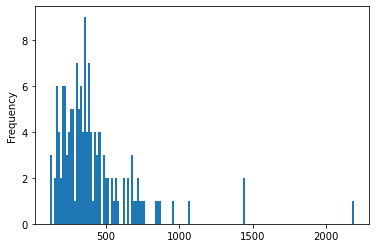

In [54]:
raw.TotalRate.plot.hist(bins=150)

In [55]:
LDnormed = raw.copy()
for c in raw.columns.values:
    LDnormed[c] = rs.fit_transform(raw[c].values.reshape(-1,1))
    print("The range of {} is [{}, {}]".format(c, LDnormed[c].min(), LDnormed[c].max()))
LDnormed.head()

The range of AssaultRate is [-0.4650996040776879, 3.7598902640521232]
The range of AutoTheftRate is [-0.5419517986236451, 3.7336280367156665]
The range of BreakEnterRate is [-0.4192454764063545, 2.619610780410243]
The range of RobberyRate is [-0.3965311796637096, 4.215259783246013]
The range of TheftOverRate is [-0.36141839672677667, 3.300121230489468]
The range of TotalRate is [-0.4736441916498795, 3.6183888296401614]


,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate,TotalRate
Hood_ID,,,,,,
1,0.172242,3.485479,0.152758,0.852547,2.026822,1.007416
2,-0.132026,0.571004,-0.319575,0.062700,0.098500,-0.106677
3,0.014029,1.228199,0.024704,0.151217,0.370132,0.247196
4,-0.054369,1.199726,-0.107226,-0.396531,-0.361418,0.063070
5,-0.162110,0.989122,-0.071812,-0.396531,-0.361418,-0.037633


<AxesSubplot:xlabel='AssaultRate', ylabel='TotalRate'>

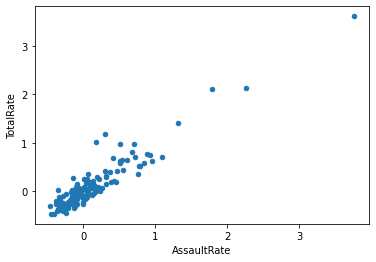

In [56]:
LDnormed.plot.scatter(x= 'AssaultRate', y='TotalRate')

## Functions

In [57]:
# A function for mapping the clustering results:

def mapping_clusters(labels_cluster):
    LD['cluster_nm'] = labels_cluster
    LD.plot(column='cluster_nm', categorical=True, legend=True, figsize=(12,8), cmap='Paired');

In [58]:
# A function for the radar plot of the cluster centroids:
# adapted from this tutorial: https://towardsdatascience.com/how-to-make-stunning-radar-charts-with-python-implemented-in-matplotlib-and-plotly-91e21801d8ca

def radar_plot_cluster_centroids(df_cluster_centroid):
    # parameters
    # df_cluster_centroid: a dataframe with rows representing a cluster centroid and columns representing variables
    
    # add an additional element to both categories and restaurants that’s identical to the first item
    # manually 'close' the line
    categories = df_cluster_centroid.columns.values.tolist()
    categories = [*categories, categories[0]]
    
    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(categories))
    
    plt.figure(figsize=(12, 8))
    plt.subplot(polar=True)
    for index, row in df_cluster_centroid.iterrows():
        centroid = row.tolist()
        centroid = [*centroid, centroid[0]]
        label = "Cluster {}".format(index)
        plt.plot(label_loc, centroid, label=label)
    plt.title('Cluster centroid comparison', size=20, y=1.05)
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
    plt.legend()
    plt.show()

### Kmeans

In [59]:
# we will try k=6 to start

from sklearn.cluster import KMeans

k_cluster = 6
random_seed = 1
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(LDnormed)

KMeans(n_clusters=6, random_state=1)

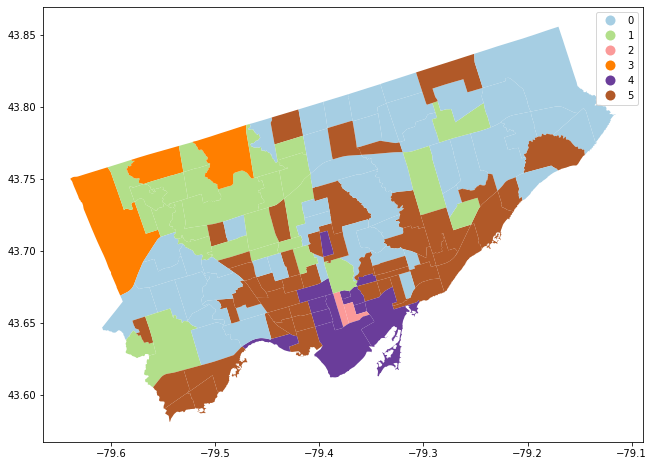

In [60]:
mapping_clusters(kmeans_method.labels_);

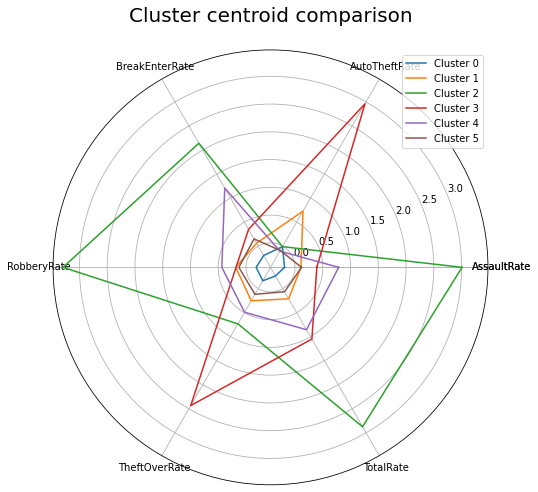

In [61]:
df_cluster_centroid = pd.DataFrame(kmeans_method.cluster_centers_, columns=LDnormed.columns)
radar_plot_cluster_centroids(df_cluster_centroid)

### Elbow method

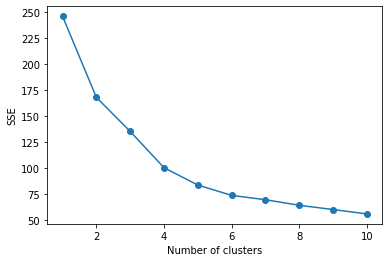

In [62]:
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 1
max_k = 10
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(LDnormed)
    # inertia is a concept from physics. Roughly it means SSE of clustering.
    list_SSE.append(km.inertia_)

# plot
plt.plot(range_k, list_SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

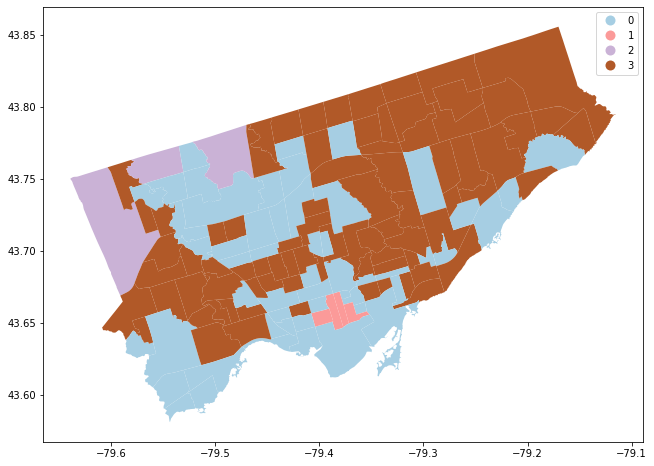

In [63]:
# Elbow method suggest 4 as optimal
k_cluster = 4
random_seed = 123
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(LDnormed)

# plotting
mapping_clusters(kmeans_method.labels_);

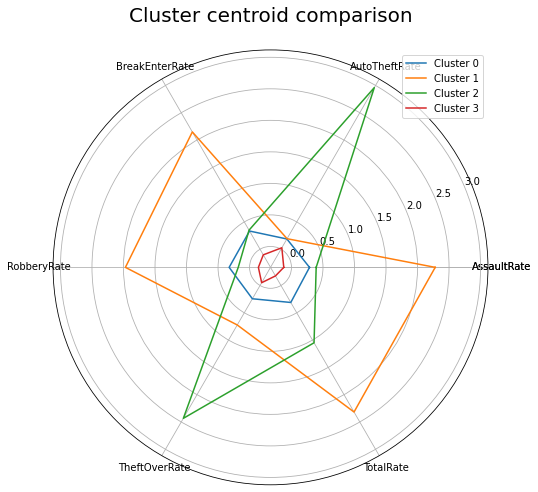

In [64]:
df_cluster_centroid = pd.DataFrame(kmeans_method.cluster_centers_, columns=LDnormed.columns)
radar_plot_cluster_centroids(df_cluster_centroid)

In [65]:
LD.head()

,index,Hood_ID,TotalRate,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate,Neighbourhood,geometry,cluster_nm
0,0,1,867.56,234.15,417.27,87.06,66.04,63.04,West Humber-Clairville,"POLYGON ((-79.55236 43.70947, -79.55238 43.709...",2
1,1,2,303.45,136.55,115.31,15.17,24.28,12.14,Mount Olive-Silverstone-Jamestown,"POLYGON ((-79.60338 43.75786, -79.60205 43.758...",3
2,2,3,482.63,183.40,183.40,67.57,28.96,19.31,Thistletown-Beaumond Heights,"POLYGON ((-79.57751 43.73384, -79.57806 43.734...",0
3,3,4,389.40,161.46,180.45,47.49,0.00,0.00,Rexdale-Kipling,"POLYGON ((-79.55512 43.71510, -79.55504 43.714...",3
4,4,5,338.41,126.90,158.63,52.88,0.00,0.00,Elms-Old Rexdale,"POLYGON ((-79.55512 43.71510, -79.55569 43.716...",3


In [66]:
# LD k-means clusters





### Regionalisation: max-p problem

In [67]:
plt.rcParams["figure.figsize"] = [12, 8]
warnings.filterwarnings("ignore")

RANDOM_SEED = 123456

In [68]:
attrs_name = LDnormed.columns.values.tolist()
attrs_name

['AssaultRate',
 'AutoTheftRate',
 'BreakEnterRate',
 'RobberyRate',
 'TheftOverRate',
 'TotalRate']

In [69]:
w = libpysal.weights.Queen.from_dataframe(nbs)

In [70]:
threshold = 0.2 * LDnormed.shape[0]
print(threshold)
LDnormed_copy = LDnormed.copy()
LDnormed_copy["count"] = 1
threshold_name = "count"

28.0


In [71]:
%%time
np.random.seed(RANDOM_SEED)
model = MaxP(LDnormed_copy, w, attrs_name, threshold_name, threshold, top_n=3)
model.solve()

CPU times: user 382 ms, sys: 51 µs, total: 383 ms
Wall time: 379 ms


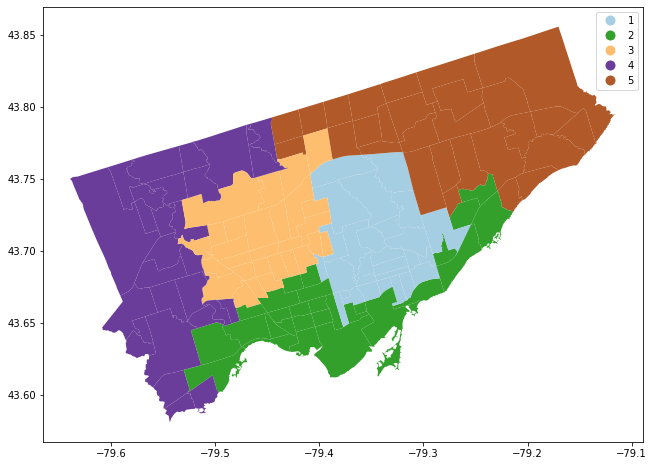

In [72]:
nbs['cluster_max_p'] = model.labels_
nbs.plot(column='cluster_max_p', categorical=True, legend=True, figsize=(12,8), cmap='Paired');

In [73]:
nbs.head()

,Hood_ID,Neighbourhood,geometry,cluster_max_p
0,93,Dovercourt-Wallace Emerson-Junction,"POLYGON ((-79.41842 43.66358, -79.41887 43.663...",2
1,121,Oakridge,"POLYGON ((-79.26986 43.69584, -79.27009 43.695...",2
2,110,Keelesdale-Eglinton West,"POLYGON ((-79.47242 43.67922, -79.47277 43.679...",3
3,108,Briar Hill-Belgravia,"POLYGON ((-79.46462 43.69216, -79.46473 43.692...",3
4,45,Parkwoods-Donalda,"POLYGON ((-79.33055 43.73979, -79.33065 43.739...",1


In [74]:
# LD max p clusters





## Crime Clustering without Lockdown from March 23, 2019 to July 31, 2019

## Preparation

In [75]:
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)

In [76]:
tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}

In [77]:
nbs = gpd.read_file('data/geo/tor_nbs.gpkg')
nbs.columns

Index(['_id', 'Hood_ID', 'Neighbourhood', 'Pop', 'geometry'], dtype='object')

In [78]:
nbs = nbs[['Hood_ID', 'Neighbourhood', 'geometry']]

In [79]:
noLD = pd.merge(noLD, nbs, left_on='Hood_ID', right_on='Hood_ID', how='inner').reset_index()
noLD = GeoDataFrame(noLD)
noLD.shape

(140, 10)

In [80]:
noLD.head()

,index,Hood_ID,TotalRate,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate,Neighbourhood,geometry
0,0,1,1065.68,303.19,504.32,138.09,51.03,69.04,West Humber-Clairville,"POLYGON ((-79.55236 43.70947, -79.55238 43.709..."
1,1,2,494.63,285.25,106.21,21.24,66.76,15.17,Mount Olive-Silverstone-Jamestown,"POLYGON ((-79.60338 43.75786, -79.60205 43.758..."
2,2,3,627.41,279.92,193.05,106.18,28.96,19.31,Thistletown-Beaumond Heights,"POLYGON ((-79.57751 43.73384, -79.57806 43.734..."
3,3,4,484.38,199.45,161.46,66.48,56.99,0.00,Rexdale-Kipling,"POLYGON ((-79.55512 43.71510, -79.55504 43.714..."
4,4,5,412.44,179.78,105.75,31.73,74.03,21.15,Elms-Old Rexdale,"POLYGON ((-79.55512 43.71510, -79.55569 43.716..."


### Raw Crime Distribution - No Lockdown

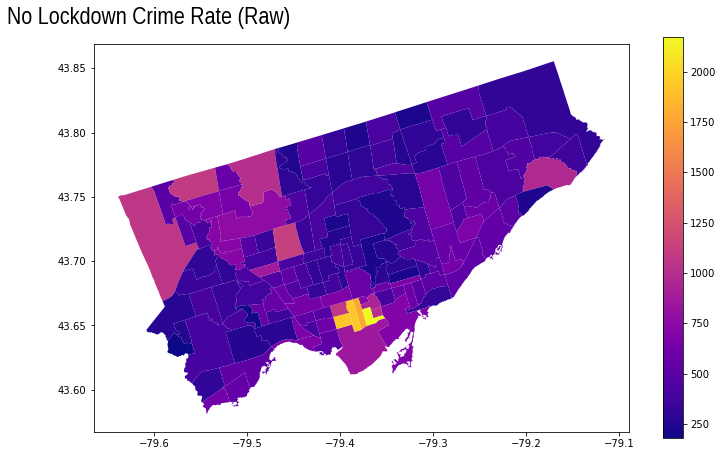

In [81]:
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
noLD.plot(column='TotalRate', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

f.subplots_adjust(top=0.92)
f.suptitle(f"No Lockdown Crime Rate (Raw)", x=0.025, size=24, **tfont);
#plt.savefig('Cluster-House-Prices-Raw.png', dpi=150)

### Raw Assault Distribution - No Lockdown 

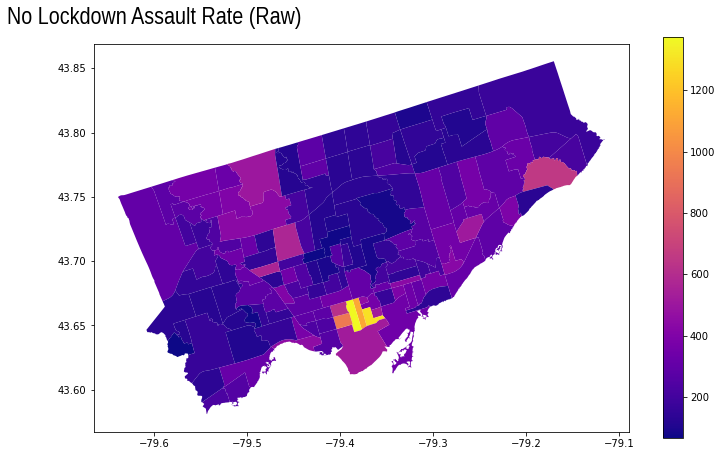

In [82]:
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
noLD.plot(column='AssaultRate', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

f.subplots_adjust(top=0.92)
f.suptitle(f"No Lockdown Assault Rate (Raw)", x=0.025, size=24, **tfont);
#plt.savefig('Cluster-House-Prices-Raw.png', dpi=150)

### Raw Auto Theft Distribution - No Lockdown 

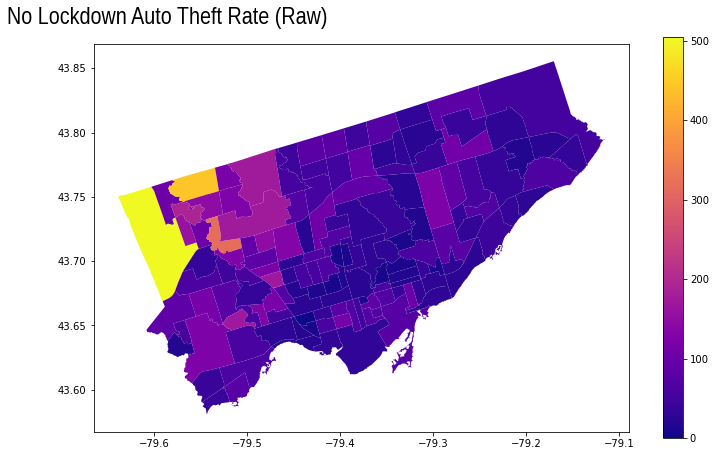

In [83]:
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
noLD.plot(column='AutoTheftRate', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

f.subplots_adjust(top=0.92)
f.suptitle(f"No Lockdown Auto Theft Rate (Raw)", x=0.025, size=24, **tfont);
#plt.savefig('Cluster-House-Prices-Raw.png', dpi=150)

### Raw Break and Enter Distribution - No Lockdown 

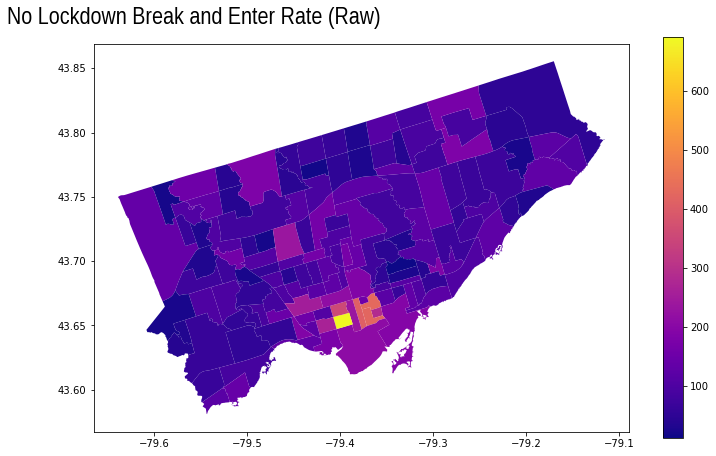

In [84]:
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
noLD.plot(column='BreakEnterRate', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

f.subplots_adjust(top=0.92)
f.suptitle(f"No Lockdown Break and Enter Rate (Raw)", x=0.025, size=24, **tfont);
#plt.savefig('Cluster-House-Prices-Raw.png', dpi=150)

### Raw Robbery Distribution - No Lockdown 

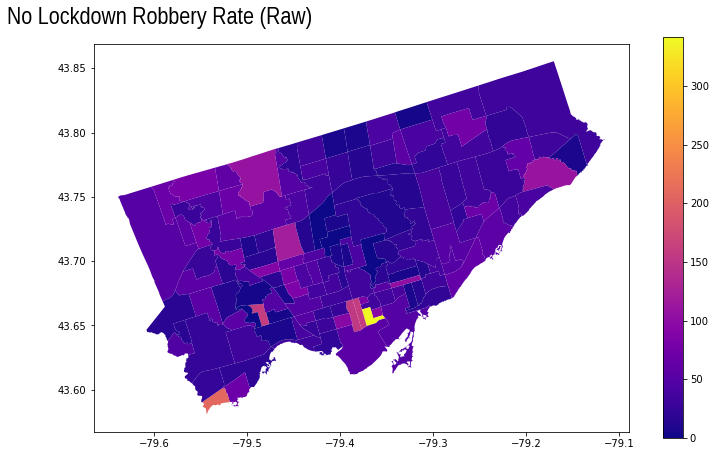

In [85]:
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
noLD.plot(column='RobberyRate', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

f.subplots_adjust(top=0.92)
f.suptitle(f"No Lockdown Robbery Rate (Raw)", x=0.025, size=24, **tfont);
#plt.savefig('Cluster-House-Prices-Raw.png', dpi=150)

### Raw Theft Over Distribution - No Lockdown 

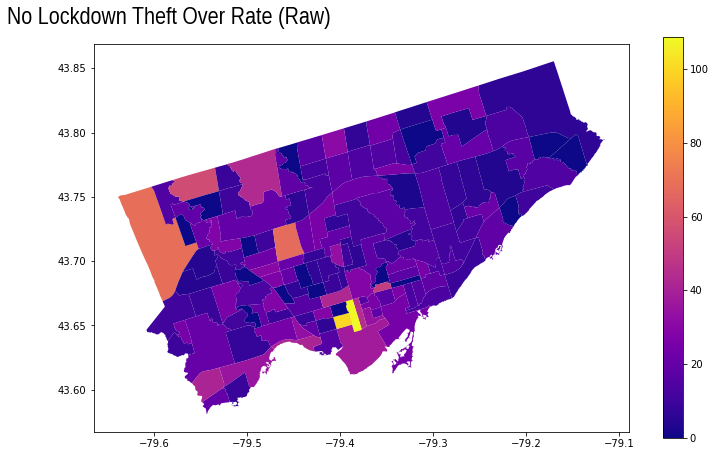

In [86]:
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
noLD.plot(column='TheftOverRate', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

f.subplots_adjust(top=0.92)
f.suptitle(f"No Lockdown Theft Over Rate (Raw)", x=0.025, size=24, **tfont);
#plt.savefig('Cluster-House-Prices-Raw.png', dpi=150)

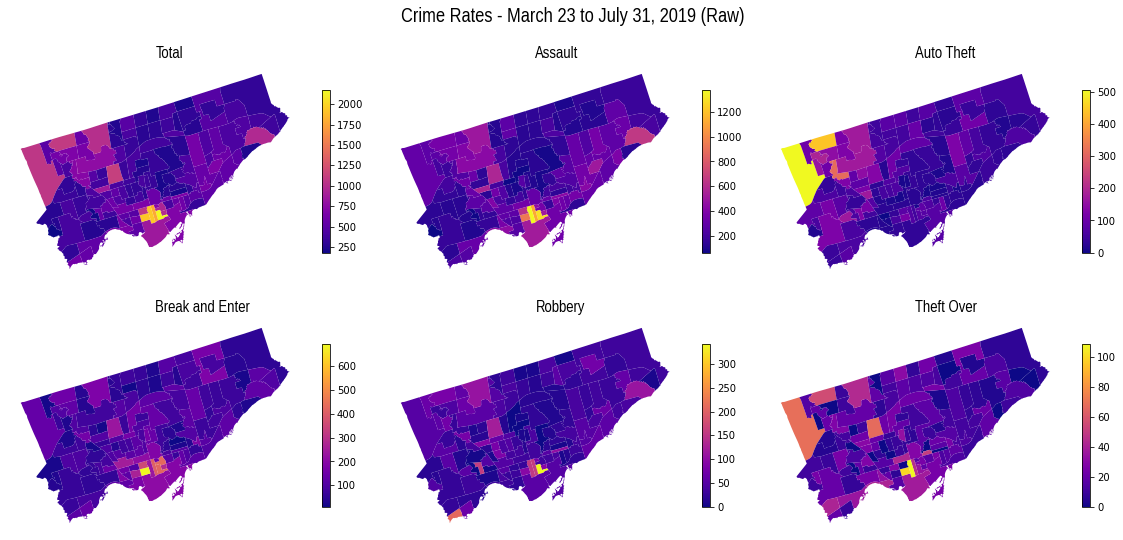

In [87]:
# plots combined 

f = plt.figure()
f.set_size_inches(16, 8)
f.suptitle(f"Crime Rates - March 23 to July 31, 2019 (Raw)", ha='center', size=20, **tfont)

ax1 = plt.subplot(2, 3, 1)
plt.title('Total', fontsize=16, color='black', **tfont)
plt.axis('off')
noLD.plot(column='TotalRate', legend=True, legend_kwds={'shrink': 0.6}, cmap='plasma', figsize=(6,4), ax=ax1)
 
ax2 = plt.subplot(2, 3, 2)
plt.title('Assault', fontsize=16, color='black', **tfont)
plt.axis('off')
noLD.plot(column='AssaultRate', legend=True, legend_kwds={'shrink': 0.6}, cmap='plasma', figsize=(6,4), ax=ax2)

ax3 = plt.subplot(2, 3, 3)
plt.title('Auto Theft', fontsize=16, color='black', **tfont)
plt.axis('off')
noLD.plot(column='AutoTheftRate', legend=True, legend_kwds={'shrink': 0.6}, cmap='plasma', figsize=(6,4), ax=ax3)

ax4 = plt.subplot(2, 3, 4)
plt.title('Break and Enter', fontsize=16, color='black', **tfont)
plt.axis('off')
noLD.plot(column='BreakEnterRate', legend=True, legend_kwds={'shrink': 0.6}, cmap='plasma', figsize=(6,4), ax=ax4)

ax5 = plt.subplot(2, 3, 5)
plt.title('Robbery', fontsize=16, color='black', **tfont)
plt.axis('off')
noLD.plot(column='RobberyRate', legend=True, legend_kwds={'shrink': 0.6}, cmap='plasma', figsize=(6,4), ax=ax5)

ax6 = plt.subplot(2, 3, 6)
plt.title('Theft Over', fontsize=16, color='black', **tfont)
plt.axis('off')
noLD.plot(column='TheftOverRate', legend=True, legend_kwds={'shrink': 0.6}, cmap='plasma', figsize=(6,4), ax=ax6)

f.tight_layout()
#plt.savefig('Cluster-House-Prices-Raw.png', dpi=150)

## Standardize

In [88]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
rs = RobustScaler(quantile_range=(10.0, 90.0))

In [89]:
noLD.head()

,index,Hood_ID,TotalRate,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate,Neighbourhood,geometry
0,0,1,1065.68,303.19,504.32,138.09,51.03,69.04,West Humber-Clairville,"POLYGON ((-79.55236 43.70947, -79.55238 43.709..."
1,1,2,494.63,285.25,106.21,21.24,66.76,15.17,Mount Olive-Silverstone-Jamestown,"POLYGON ((-79.60338 43.75786, -79.60205 43.758..."
2,2,3,627.41,279.92,193.05,106.18,28.96,19.31,Thistletown-Beaumond Heights,"POLYGON ((-79.57751 43.73384, -79.57806 43.734..."
3,3,4,484.38,199.45,161.46,66.48,56.99,0.00,Rexdale-Kipling,"POLYGON ((-79.55512 43.71510, -79.55504 43.714..."
4,4,5,412.44,179.78,105.75,31.73,74.03,21.15,Elms-Old Rexdale,"POLYGON ((-79.55512 43.71510, -79.55569 43.716..."


In [90]:
raw = noLD[['Hood_ID','AssaultRate','AutoTheftRate', 'BreakEnterRate', 'RobberyRate', 'TheftOverRate', 'TotalRate']].set_index('Hood_ID').copy()
raw.head()

,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate,TotalRate
Hood_ID,,,,,,
1,303.19,504.32,138.09,51.03,69.04,1065.68
2,285.25,106.21,21.24,66.76,15.17,494.63
3,279.92,193.05,106.18,28.96,19.31,627.41
4,199.45,161.46,66.48,56.99,0.00,484.38
5,179.78,105.75,31.73,74.03,21.15,412.44


<AxesSubplot:ylabel='Frequency'>

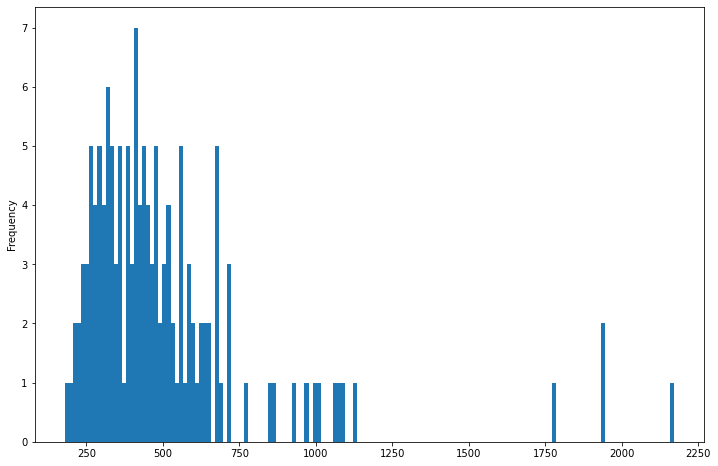

In [91]:
raw.TotalRate.plot.hist(bins=150)

In [92]:
noLDnormed = raw.copy()
for c in raw.columns.values:
    noLDnormed[c] = rs.fit_transform(raw[c].values.reshape(-1,1))
    print("The range of {} is [{}, {}]".format(c, noLDnormed[c].min(), noLDnormed[c].max()))
noLDnormed.head()

The range of AssaultRate is [-0.5175365298732836, 3.569427883817945]
The range of AutoTheftRate is [-0.4741180200172094, 4.09379104207237]
The range of BreakEnterRate is [-0.5494070629173943, 3.8995506367614436]
The range of RobberyRate is [-0.4638112371990036, 4.260240797121506]
The range of TheftOverRate is [-0.42474689335576604, 2.779007644853744]
The range of TotalRate is [-0.49640809526142904, 3.4043514480325325]


,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate,TotalRate
Hood_ID,,,,,,
1,0.223733,4.093791,0.282994,0.242389,1.613094,1.239565
2,0.167588,0.487886,-0.481316,0.460075,0.023023,0.120243
3,0.150908,1.274444,0.074272,-0.063036,0.145223,0.380507
4,-0.100929,0.988316,-0.185403,0.324869,-0.424747,0.100152
5,-0.162487,0.483719,-0.412701,0.560684,0.199534,-0.040859


<AxesSubplot:xlabel='AssaultRate', ylabel='TotalRate'>

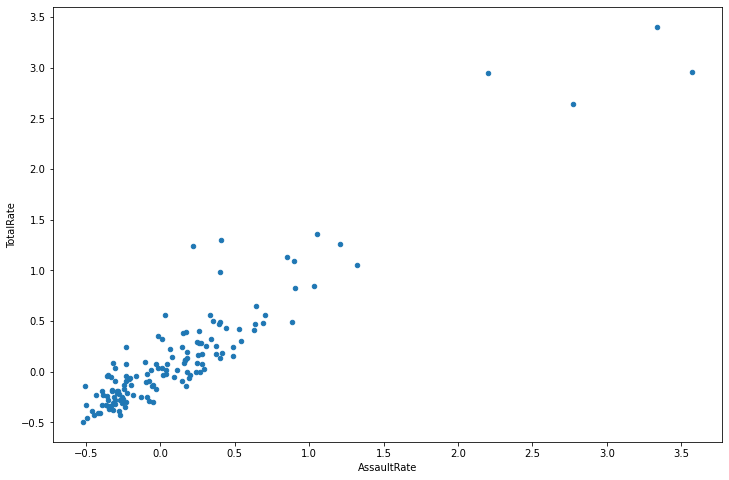

In [93]:
noLDnormed.plot.scatter(x= 'AssaultRate', y='TotalRate')

## Functions

In [94]:
# A function for mapping the clustering results:

def mapping_clusters(labels_cluster):
    noLD['cluster_nm'] = labels_cluster
    noLD.plot(column='cluster_nm', categorical=True, legend=True, figsize=(12,8), cmap='Paired');

In [95]:
# A function for the radar plot of the cluster centroids:
# adapted from this tutorial: https://towardsdatascience.com/how-to-make-stunning-radar-charts-with-python-implemented-in-matplotlib-and-plotly-91e21801d8ca

def radar_plot_cluster_centroids(df_cluster_centroid):
    # parameters
    # df_cluster_centroid: a dataframe with rows representing a cluster centroid and columns representing variables
    
    # add an additional element to both categories and restaurants that’s identical to the first item
    # manually 'close' the line
    categories = df_cluster_centroid.columns.values.tolist()
    categories = [*categories, categories[0]]
    
    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(categories))
    
    plt.figure(figsize=(12, 8))
    plt.subplot(polar=True)
    for index, row in df_cluster_centroid.iterrows():
        centroid = row.tolist()
        centroid = [*centroid, centroid[0]]
        label = "Cluster {}".format(index)
        plt.plot(label_loc, centroid, label=label)
    plt.title('Cluster centroid comparison', size=20, y=1.05)
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
    plt.legend()
    plt.show()

### Kmeans

In [96]:
# we will again try k=6 to start

from sklearn.cluster import KMeans

k_cluster = 6
random_seed = 1
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(noLDnormed)

KMeans(n_clusters=6, random_state=1)

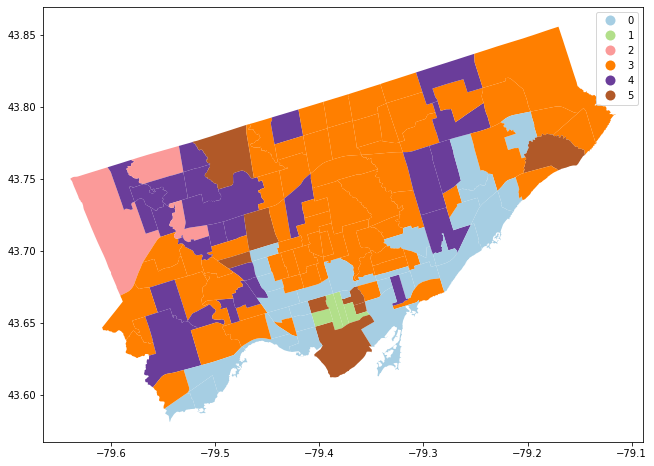

In [97]:
mapping_clusters(kmeans_method.labels_);

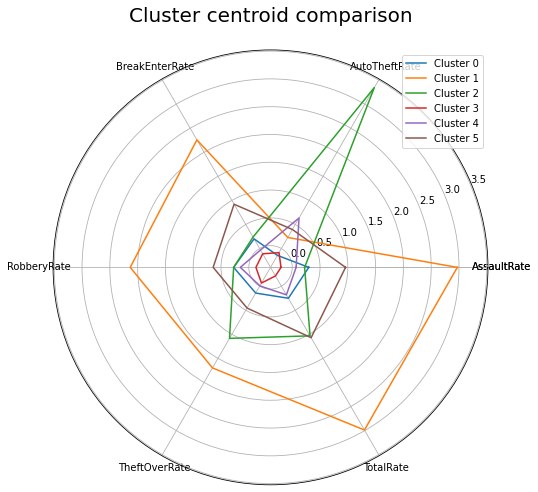

In [98]:
df_cluster_centroid = pd.DataFrame(kmeans_method.cluster_centers_, columns=noLDnormed.columns)
radar_plot_cluster_centroids(df_cluster_centroid)

### Elbow method

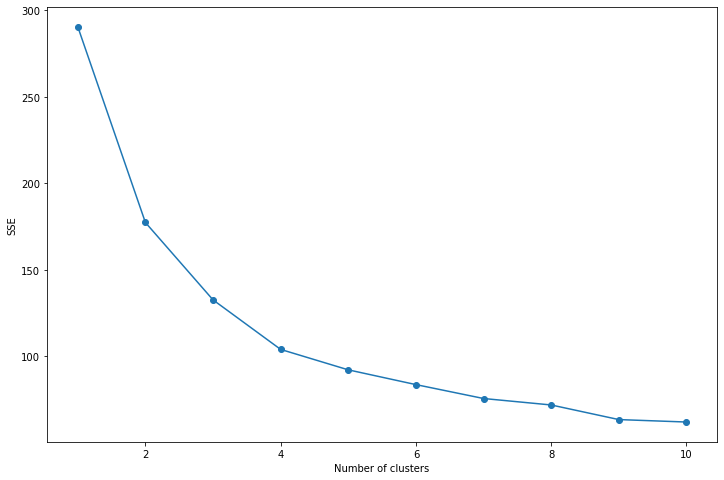

In [99]:
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 1
max_k = 10
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(noLDnormed)
    # inertia is a concept from physics. Roughly it means SSE of clustering.
    list_SSE.append(km.inertia_)

# plot
plt.plot(range_k, list_SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

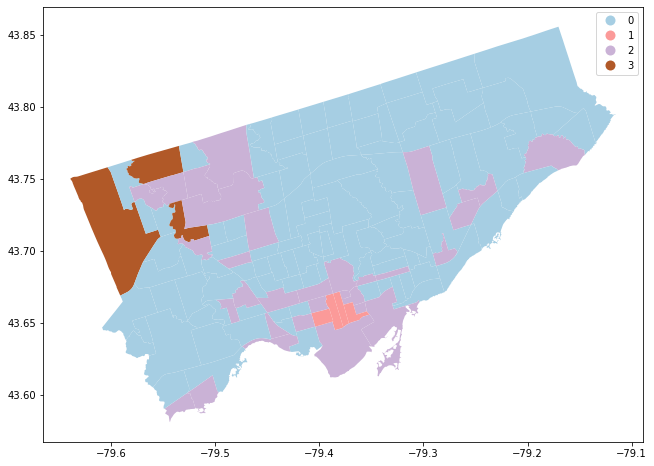

In [100]:
# elbow method suggests 3 as optimal
k_cluster = 4
random_seed = 123
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(noLDnormed)

# plotting
mapping_clusters(kmeans_method.labels_);

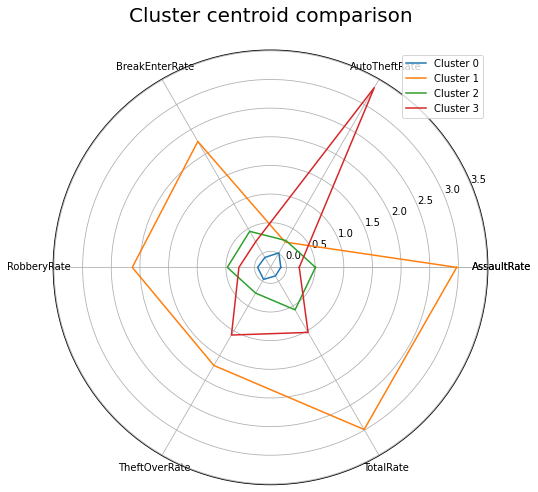

In [101]:
df_cluster_centroid = pd.DataFrame(kmeans_method.cluster_centers_, columns=noLDnormed.columns)
radar_plot_cluster_centroids(df_cluster_centroid)

In [102]:
# no LD k-means clusters





### Regionalisation: max-p problem

In [103]:
plt.rcParams["figure.figsize"] = [12, 8]
warnings.filterwarnings("ignore")

RANDOM_SEED = 123456

In [104]:
attrs_name = noLDnormed.columns.values.tolist()
attrs_name

['AssaultRate',
 'AutoTheftRate',
 'BreakEnterRate',
 'RobberyRate',
 'TheftOverRate',
 'TotalRate']

In [105]:
w = libpysal.weights.Queen.from_dataframe(nbs)

In [106]:
threshold = 0.2 * noLDnormed.shape[0]
print(threshold)
noLDnormed_copy = noLDnormed.copy()
noLDnormed_copy["count"] = 1
threshold_name = "count"

28.0


In [107]:
%%time
np.random.seed(RANDOM_SEED)
model = MaxP(noLDnormed_copy, w, attrs_name, threshold_name, threshold, top_n=3)
model.solve()

CPU times: user 362 ms, sys: 19.2 ms, total: 382 ms
Wall time: 380 ms


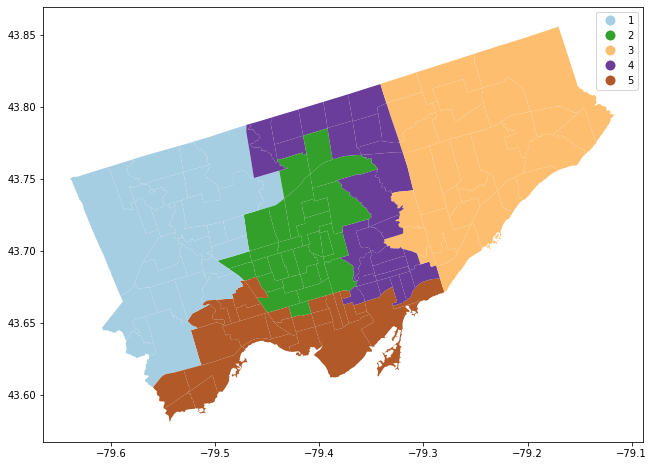

In [108]:
nbs['cluster_max_p'] = model.labels_
nbs.plot(column='cluster_max_p', categorical=True, legend=True, figsize=(12,8), cmap='Paired');

In [109]:
# no max p clusters



